# Initialize Datasets
## Places

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import json
from tqdm import tqdm

### Dataset Parameters

In [38]:
ds_path = "/homes/ukumaras/scratch/twitter-data/tweets.csv"
output_dir = "/homes/ukumaras/scratch/twitter-data/"

num_objects = 100000 * 2
num_queries = 20000000

should_scale = True
grid_range = 512
spatial_uni = False
spatial_skew = False
text_uni = False
fixed_max_keywords = True
min_keywords = 1
max_keywords = 3

seed = 7

### Load Data

In [39]:
content = []

with open(ds_path, "r") as f:
    place_id = 0
    i = 0
    for line in tqdm(f):
        if (len(content) >= num_objects + num_queries):
            break

        tweet = line.split(",")[1:-2]
                
        keywords = tweet[2].split("|")
        if (len(keywords) < min_keywords):
            continue

        content.append({
            "id": i,
            "x": float(tweet[0]),
            "y": float(tweet[1]),
            "keywords": keywords,
            "scaled": False
        })
        i += 1

df = pd.DataFrame(content)
df.head()

20200000it [02:01, 166555.32it/s]


,id,x,y,keywords,scaled
0,0,371.814059,350.042969,"[2012, ass, bitches, change, involved, law, li...",False
1,1,175.958757,334.624089,"[fresh, great, happynewyear, keystone, night, ...",False
2,2,486.481562,428.411198,"[glad, kinda, lmao, minute, ohya]",False
3,3,388.960237,329.788216,"[cold, early, eat, mornin, pizza, pussy, wake]",False
4,4,417.501886,370.202865,"[happy, year]",False


### Pre-process

In [40]:
def scale(c, minc, maxc):
    return (c - minc) * grid_range / (maxc - minc)


if should_scale and not (spatial_uni or spatial_skew):
    minx = df['x'].min()
    miny = df['y'].min()
    maxx = df['x'].max()
    maxy = df['y'].max()
    
    df['x'] = df['x'].apply(lambda x: scale(x, minx, maxx))
    df['y'] = df['y'].apply(lambda y: scale(y, miny, maxy))
    df['scaled'] = True

df.head()

,id,x,y,keywords,scaled
0,0,380.956350,338.441674,"[2012, ass, bitches, change, involved, law, li...",True
1,1,179.213754,321.918190,"[fresh, great, happynewyear, keystone, night, ...",True
2,2,499.070690,422.424178,"[glad, kinda, lmao, minute, ohya]",True
3,3,398.617932,316.735877,"[cold, early, eat, mornin, pizza, pussy, wake]",True
4,4,428.017526,360.045818,"[happy, year]",True


### Uniform Sample

In [41]:
if spatial_uni:
    sample = pd.DataFrame(np.random.uniform(0, 512, (num_objects + num_queries, 2)), columns=['x', 'y'])
    
    df['x'] = sample['x']
    df['y'] = sample['y']

df.head()

,id,x,y,keywords,scaled
0,0,380.956350,338.441674,"[2012, ass, bitches, change, involved, law, li...",True
1,1,179.213754,321.918190,"[fresh, great, happynewyear, keystone, night, ...",True
2,2,499.070690,422.424178,"[glad, kinda, lmao, minute, ohya]",True
3,3,398.617932,316.735877,"[cold, early, eat, mornin, pizza, pussy, wake]",True
4,4,428.017526,360.045818,"[happy, year]",True


### Skew Gaussian Sample

In [42]:
if spatial_skew:
    from scipy.interpolate import interp1d
    from scipy.stats import skewnorm
    
    x,y = skewnorm.rvs(4, size=num_objects + num_queries),skewnorm.rvs(4, size=num_objects + num_queries)

    m_x = interp1d([min(x), max(x)],[0,512])
    m_y = interp1d([min(y), max(y)],[0,512])
    df['x'] = m_x(x)
    df['y'] = m_y(y)

df.head()

,id,x,y,keywords,scaled
0,0,380.956350,338.441674,"[2012, ass, bitches, change, involved, law, li...",True
1,1,179.213754,321.918190,"[fresh, great, happynewyear, keystone, night, ...",True
2,2,499.070690,422.424178,"[glad, kinda, lmao, minute, ohya]",True
3,3,398.617932,316.735877,"[cold, early, eat, mornin, pizza, pussy, wake]",True
4,4,428.017526,360.045818,"[happy, year]",True


### Text Uniform

In [43]:
import itertools
import random

vocab = pd.Series(itertools.chain.from_iterable(df['keywords'].values)).drop_duplicates().values

if text_uni:
    sample = np.random.uniform(0, 512, (num_objects + num_queries, 2))
    sample = [[vocab[i] for i in random.sample(range(0, len(vocab)), 3)] for j in range(df.shape[0])]
    
    df['keywords'] = sample

df.head()

,id,x,y,keywords,scaled
0,0,380.956350,338.441674,"[2012, ass, bitches, change, involved, law, li...",True
1,1,179.213754,321.918190,"[fresh, great, happynewyear, keystone, night, ...",True
2,2,499.070690,422.424178,"[glad, kinda, lmao, minute, ohya]",True
3,3,398.617932,316.735877,"[cold, early, eat, mornin, pizza, pussy, wake]",True
4,4,428.017526,360.045818,"[happy, year]",True


### Fixed max keys

In [44]:
if fixed_max_keywords:
    import random

    def clamp_keywords(keywords):
        if (len(keywords) < max_keywords):
            return keywords
        return sorted(random.sample(keywords, max_keywords))
    df['keywords'] = df['keywords'].apply(clamp_keywords)

df.head()

,id,x,y,keywords,scaled
0,0,380.956350,338.441674,"[listen, stupid, thing]",True
1,1,179.213754,321.918190,"[great, happynewyear, night]",True
2,2,499.070690,422.424178,"[kinda, lmao, minute]",True
3,3,398.617932,316.735877,"[eat, pizza, wake]",True
4,4,428.017526,360.045818,"[happy, year]",True


### Visualize

<Axes: xlabel='x', ylabel='y'>

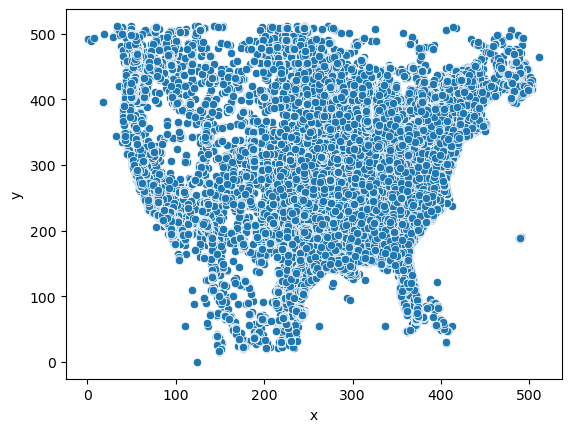

In [45]:
sns.scatterplot(x="x", y="y", data=df.loc[:, ["x", "y"]].sample(1000000))

### Export

In [46]:
output_name = f'{output_dir}tweets_o{num_objects}_q{num_queries}'

if (should_scale and not (spatial_uni or spatial_skew)):
    output_name += f'_scaled'

if (spatial_uni):
    output_name += f'_spatialuni'


if (spatial_skew):
    output_name += f'_spatialskew'

if (text_uni):
    output_name += f'_textuni'

if (text_uni):
    output_name += f'_textuni'

if (fixed_max_keywords != 0):
    output_name += f'_max_keys' + str(max_keywords)

df.to_json(f'{output_name}.json', orient='records', lines=True)
print(f'{output_name}.json')

/homes/ukumaras/scratch/twitter-data/tweets_o200000_q20000000_scaled_max_keys3.json


In [47]:
df.shape

(20200000, 5)

In [48]:
output_name

'/homes/ukumaras/scratch/twitter-data/tweets_o200000_q20000000_scaled_max_keys3'